In [1]:
!pip install torch torchvision matplotlib
!pip install requests

In [2]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!cd stylegan2-ada-pytorch && pip install .

fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [3]:
import torch
import matplotlib.pyplot as plt

# Download the pretrained StyleGAN2 model weights
model_url = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
!wget -O ffhq.pkl {model_url}

--2025-03-13 20:34:08--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 2600:9000:256c:fc00:1d:f824:b300:93a1, 2600:9000:256c:8e00:1d:f824:b300:93a1, 2600:9000:256c:5a00:1d:f824:b300:93a1, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|2600:9000:256c:fc00:1d:f824:b300:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: 'ffhq.pkl'

     0K .......... .......... .......... .......... ..........  0%  604K 10m17s
    50K .......... .......... .......... .......... ..........  0%  989K 8m17s
   100K .......... .......... .......... .......... ..........  0%  723K 8m23s
   150K .......... .......... .......... .......... ..........  0% 2.06M 7m1s
   200K .......... .......... .......... .......... ..........  0% 2.30M 6m9s
   250K .......... .......... .......... .......... ..........  0% 1.03M 6m6s
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.039708376..1.0214487].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.101248324..1.1022242].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16469371..1.1917961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09787506..1.1317211].


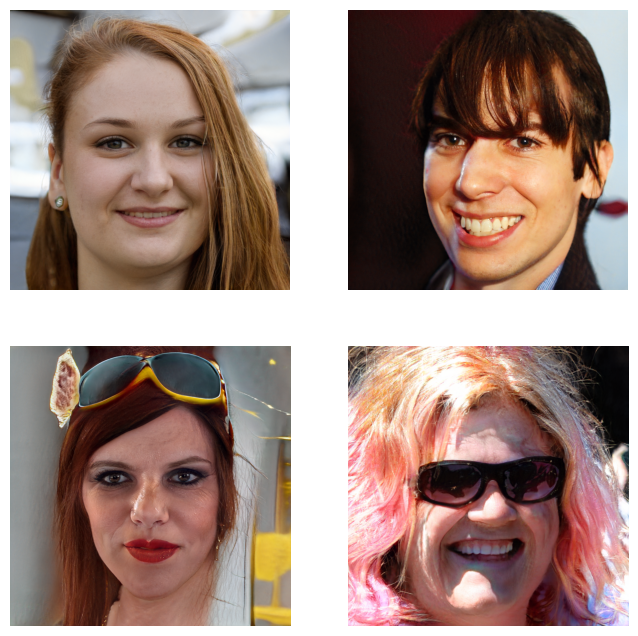

In [6]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('stylegan2-ada-pytorch')  # Add repo to Python path
import dnnlib
import legacy

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load StyleGAN2 model
with dnnlib.util.open_url('ffhq.pkl') as f:
    generator = legacy.load_network_pkl(f)['G_ema'].to(device)

generator.eval()

# Generate random latent vectors
num_images = 4
latent_dim = 512
torch.manual_seed(42)
noise = torch.randn(num_images, latent_dim, device=device)

# Generate images
with torch.no_grad():
    w = generator.mapping(noise, None)
    generated_images = generator.synthesis(w, noise_mode='const')

# Rescale images from [-1, 1] to [0, 1]
generated_images = (generated_images + 1) / 2
generated_images = generated_images.cpu()

# Display the generated images
plt.figure(figsize=(8, 8))
for i in range(num_images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(generated_images[i].permute(1, 2, 0).numpy())
    plt.axis('off')
plt.show()


In [5]:
# =============================================================================
# 1. Install CLIP and Super-Resolution Libraries
# =============================================================================
!pip install ftfy regex tqdm git+https://github.com/openai/CLIP.git
!pip install realesrgan

  Cloning https://github.com/openai/CLIP.git to c:\users\udayb\appdata\local\temp\pip-req-build-4zyg5o_e
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\udayb\AppData\Local\Temp\pip-req-build-4zyg5o_e'


In [8]:
# =============================================================================
# 2. Import Required Libraries (Fixed)
# =============================================================================
import clip
import torchvision.transforms as transforms  # ADD THIS LINE
from PIL import Image
import numpy as np

In [9]:
# =============================================================================
# 3. Load CLIP Model and Define Text Prompt
# =============================================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Customize your prompt here
# Use descriptive, CLIP-friendly phrases with emphasis
text_prompt = "a realistic portrait of a young woman with pale porcelain skin, bright hazel eyes, long straight jet-black hair, a sharp jawline, delicate arched eyebrows, and a small beauty mark below her left eye"
negative_prompt = "cartoonish, pixelated, wrinkled skin, facial piercings, unnatural hair colors"
text_input = clip.tokenize([text_prompt]).to(device)

with torch.no_grad():
    text_features = clip_model.encode_text(text_input)

In [11]:
# =============================================================================
# 4. Initialize Latent Vector (Universal Fix)
# =============================================================================
num_latents = 1
initial_z = torch.randn([num_latents, generator.z_dim], device=device)

with torch.no_grad():
    # Get initial latent vector
    initial_w = generator.mapping(initial_z, None)

    # Auto-detect latent space type
    if initial_w.ndim == 2:  # W space [1, 512]
        # Calculate layers for W+ expansion
        num_layers = (int(np.log2(generator.img_resolution)) - 2) * 2 + 2
        initial_w = initial_w.unsqueeze(1).repeat(1, num_layers, 1)
    else:  # Already in W+ space [1, num_layers, 512]
        num_layers = initial_w.shape[1]

    print("Initial latent shape:", initial_w.shape)  # Should be [1, 18, 512]

w = initial_w.clone().detach().requires_grad_(True)
optimizer = torch.optim.Adam([w], lr=0.1)
lambda_reg = 0.1

Initial latent shape: torch.Size([1, 18, 512])


In [ ]:
# =============================================================================
# 5. Optimized CLIP-Guided Optimization (Faster Execution)
# =============================================================================
num_steps = 50  # Reduced from 100
lr = 0.2  # Increased from 0.1
lambda_reg = 0.05  # Reduced from 0.1

optimizer = torch.optim.Adam([w], lr=lr, betas=(0.9, 0.999))

# Encode text features once
with torch.inference_mode():
    text_features = clip_model.encode_text(text_input).half()  # Use FP16

for step in range(num_steps):
    with torch.inference_mode():  # Speed up inference
        generated_image = generator.synthesis(w.half(), noise_mode='const')

    # Apply augmentations less frequently
    if step % 50 == 0:
        generated_image = transforms.RandomPerspective(distortion_scale=0.05)(generated_image)

    img = (generated_image + 1) / 2
    img = torch.nn.functional.interpolate(img, size=224, mode='bicubic')

    img_crops = []
    for _ in range(1):  # Reduced from 2 to 1 crop
        crop = transforms.RandomResizedCrop(224)(img)
        crop = (crop - torch.tensor([0.481, 0.457, 0.408], device=device).view(1, 3, 1, 1)) / \
               torch.tensor([0.268, 0.261, 0.275], device=device).view(1, 3, 1, 1)
        img_crops.append(crop)

    img_batch = torch.cat(img_crops, dim=0)

    # Encode images
    with torch.inference_mode():  # Speed up encoding
        image_features = clip_model.encode_image(img_batch).half()

    # Compute CLIP loss
    clip_loss = 1 - torch.cosine_similarity(image_features, text_features).mean()

    # Negative prompt loss (if used)
    if negative_prompt:
        with torch.inference_mode():
            neg_input = clip.tokenize([negative_prompt]).to(device)
            neg_features = clip_model.encode_text(neg_input).half()
        clip_loss += torch.cosine_similarity(image_features, neg_features).mean() * 0.5

    # Regularization
    reg_loss = torch.norm(w - initial_w) * lambda_reg
    total_loss = clip_loss + reg_loss

    # Optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    print(f"Step {step:03d} | CLIP Loss: {clip_loss.item():.3f} | Reg Loss: {reg_loss.item():.3f}")


Step 000 | CLIP Loss: 0.931 | Reg Loss: 0.000
Step 001 | CLIP Loss: 0.923 | Reg Loss: 0.000
Step 002 | CLIP Loss: 0.908 | Reg Loss: 0.000
Step 003 | CLIP Loss: 0.921 | Reg Loss: 0.000
Step 004 | CLIP Loss: 0.928 | Reg Loss: 0.000
Step 005 | CLIP Loss: 0.911 | Reg Loss: 0.000
Step 006 | CLIP Loss: 0.936 | Reg Loss: 0.000
Step 007 | CLIP Loss: 0.915 | Reg Loss: 0.000
Step 008 | CLIP Loss: 0.898 | Reg Loss: 0.000
Step 009 | CLIP Loss: 0.913 | Reg Loss: 0.000
Step 010 | CLIP Loss: 0.923 | Reg Loss: 0.000
Step 011 | CLIP Loss: 0.949 | Reg Loss: 0.000
Step 012 | CLIP Loss: 0.911 | Reg Loss: 0.000
Step 013 | CLIP Loss: 0.932 | Reg Loss: 0.000
Step 014 | CLIP Loss: 0.908 | Reg Loss: 0.000
Step 015 | CLIP Loss: 0.918 | Reg Loss: 0.000
Step 016 | CLIP Loss: 0.917 | Reg Loss: 0.000
Step 017 | CLIP Loss: 0.916 | Reg Loss: 0.000
Step 018 | CLIP Loss: 0.917 | Reg Loss: 0.000
Step 019 | CLIP Loss: 0.901 | Reg Loss: 0.000
Step 020 | CLIP Loss: 0.937 | Reg Loss: 0.000
Step 021 | CLIP Loss: 0.887 | Reg 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024258971..1.0115821].


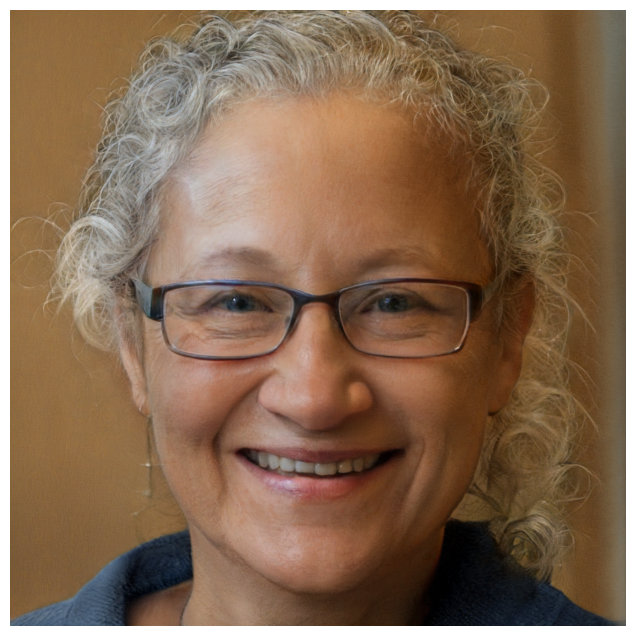

In [13]:
# =============================================================================
# 6. Generate and Show Optimized Image
# =============================================================================
with torch.no_grad():
    final_img = generator.synthesis(w, noise_mode='const')
    final_img = (final_img + 1) / 2
    final_img = final_img[0].permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(8, 8))
plt.imshow(final_img)
plt.axis('off')
plt.show()

In [18]:
!pip uninstall -y torch torchvision torchaudio basicsr gfpgan opencv-python
!pip cache purge
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.1
!pip install basicsr==1.4.2 gfpgan==1.3.8 opencv-python


Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Found existing installation: torchvision 0.21.0
Uninstalling torchvision-0.21.0:
  Successfully uninstalled torchvision-0.21.0
Found existing installation: basicsr 1.4.2
Uninstalling basicsr-1.4.2:
  Successfully uninstalled basicsr-1.4.2
Found existing installation: gfpgan 1.3.8
Uninstalling gfpgan-1.3.8:
  Successfully uninstalled gfpgan-1.3.8
Found existing installation: opencv-python 4.10.0.84
Uninstalling opencv-python-4.10.0.84:
  Successfully uninstalled opencv-python-4.10.0.84


You can safely remove it manually.


Files removed: 1141 (2159.3 MB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.

The conflict is caused by:
    The user requested torch==2.0.1
    torchvision 0.15.2 depends on torch==2.0.1
    torchaudio 2.0.1 depends on torch==2.0.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict



ERROR: Cannot install torch==2.0.1, torchaudio==2.0.1 and torchvision==0.15.2 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): still running...
  Preparing metadata (setup.py): finished with status 'done'
  Using cached torch-2.6.0-cp311-cp311-win_amd64.whl.metadata (28 kB)
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
    --------------------------------------- 0.5/39.5 MB 442.1 kB/s eta 0:01:29

In [22]:
import torch
import torchvision
import gfpgan

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("GFPGAN version:", gfpgan.__version__)


ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'